# 4. Train model. XGBoost

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from utils import (
    pr_at_thresholds,
    cm_for_threshold,
    explain_confusion_matrix
)

In [15]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = ROOT / "data"
INTERIM_DATA = DATA / "interim"

## Load data

In [16]:
X_train = pd.read_parquet(INTERIM_DATA / 'x_train_features.parquet.gzip')
X_val = pd.read_parquet(INTERIM_DATA / 'x_val_features.parquet.gzip')
X_test = pd.read_parquet(INTERIM_DATA / 'x_test_features.parquet.gzip')

y_train = X_train['tx_fraud']
y_val = X_val['tx_fraud']
y_test = X_test['tx_fraud']

FEATURES = []
with open(INTERIM_DATA / "features_list.txt", "r") as f:
    for line in f:
        FEATURES.append(line.strip())

## Train model

In [18]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb = XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train[FEATURES],
    y_train,
    eval_set=[(X_val[FEATURES], y_val)],
    verbose=50
)
y_pred_proba = xgb.predict_proba(X_val[FEATURES])[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC:  {pr_auc:.3f}")

[0]	validation_0-aucpr:0.34950
[50]	validation_0-aucpr:0.53666
[99]	validation_0-aucpr:0.53691
ROC AUC: 0.932
PR AUC:  0.537


## Visualization

### Precision-recall curve

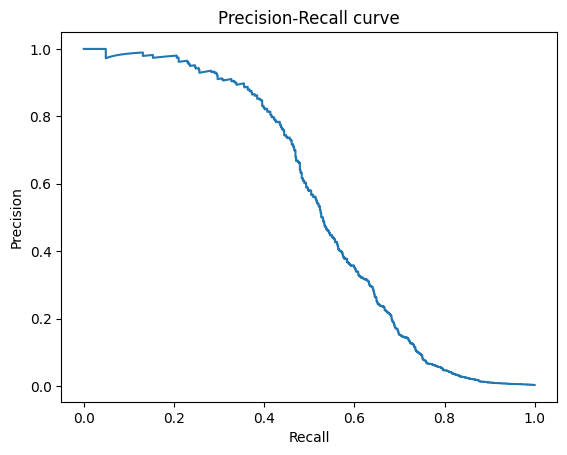

In [77]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

## Thresholds grid

In [20]:
grid = np.sort(np.unique(np.round(y_pred_proba, 3)))
rows = []

for t in sorted(set(grid)):
    y_hat = (y_pred_proba >= t).astype(int)
    
    pr = precision_score(y_val, y_hat, zero_division=0)
    rc = recall_score(y_val, y_hat, zero_division=0)
    f1 = f1_score(y_val, y_hat, zero_division=0)
    f05 = fbeta_score(y_val, y_hat, beta=0.5, zero_division=0)
    f2 = fbeta_score(y_val, y_hat, beta=2, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()
    
    rows.append((t, pr, rc, f1, f05, f2, tp, fp, fn, tn))

grid_df = pd.DataFrame(
    rows,
    columns=['thr', 'precision', 'recall', 'f1', 'f0.5', 'f2', 'TP', 'FP', 'FN', 'TN']
).sort_values('thr')

In [21]:
grid_df.head(30)

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
0,0.000,0.003098,1.000000,0.006176,0.003869,0.015298,718,231078,0,0
1,0.001,0.004757,0.979109,0.009469,0.005939,0.023333,703,147070,15,84008
2,0.002,0.005847,0.952646,0.011623,0.007298,0.028536,684,116294,34,114784
3,0.003,0.006803,0.940111,0.013509,0.008489,0.033060,675,98540,43,132538
4,0.004,0.007644,0.927577,0.015162,0.009535,0.036998,666,86466,52,144612
5,0.005,0.008435,0.916435,0.016716,0.010520,0.040678,658,77350,60,153728
6,0.006,0.009184,0.908078,0.018184,0.011451,0.044134,652,70342,66,160736
7,0.007,0.009936,0.902507,0.019656,0.012386,0.047585,648,64569,70,166509
8,0.008,0.010640,0.896936,0.021030,0.013261,0.050789,644,59883,74,171195
9,0.009,0.011373,0.892758,0.022459,0.014171,0.054107,641,55722,77,175356


In [22]:
grid_df[grid_df['f1'] == grid_df['f1'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
928,0.961,0.732739,0.458217,0.563839,0.654336,0.495333,329,120,389,230958


In [23]:
grid_df[grid_df['f0.5'] == grid_df['f0.5'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
955,0.988,0.862069,0.383008,0.530376,0.689569,0.430899,275,44,443,231034


In [24]:
grid_df[grid_df['f2'] == grid_df['f2'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
748,0.772,0.426455,0.561281,0.484666,0.447977,0.527901,403,542,315,230536
749,0.773,0.426455,0.561281,0.484666,0.447977,0.527901,403,542,315,230536


## Precision-recall curve with marked thresholds

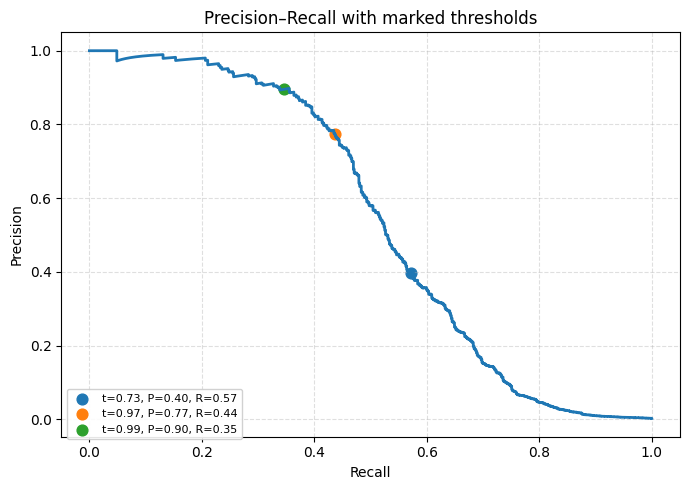

In [25]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(recall, precision, lw=2)

mark_thrs = [0.73, 0.972, 0.993]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles=[]
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc='lower left')

ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Confusion matrixes for thresholds

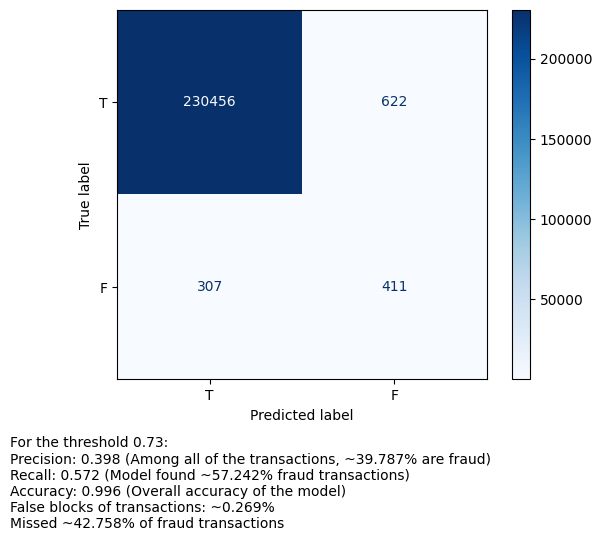

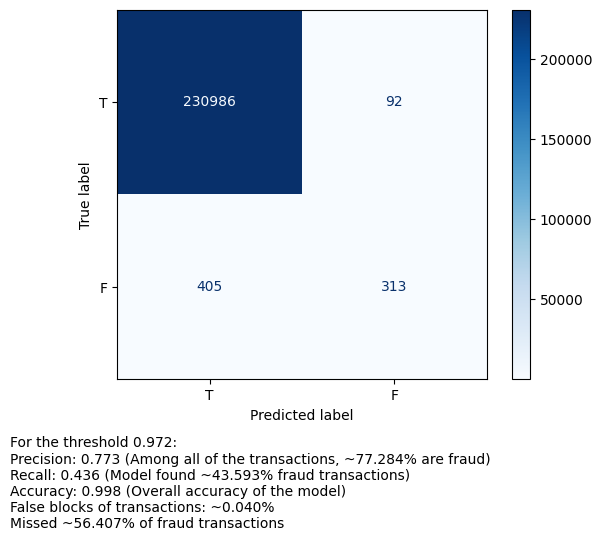

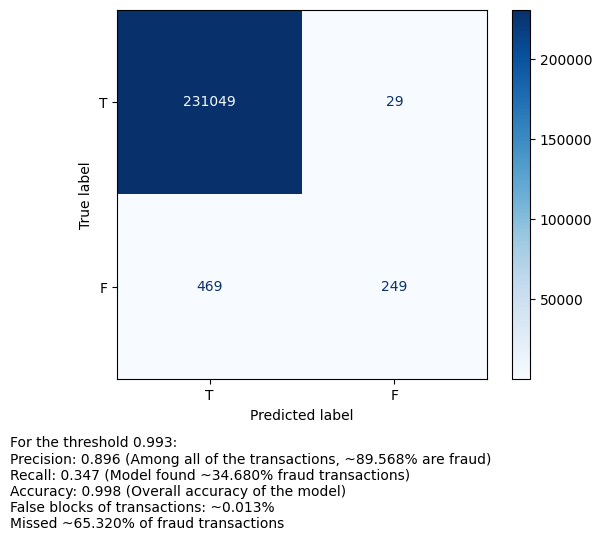

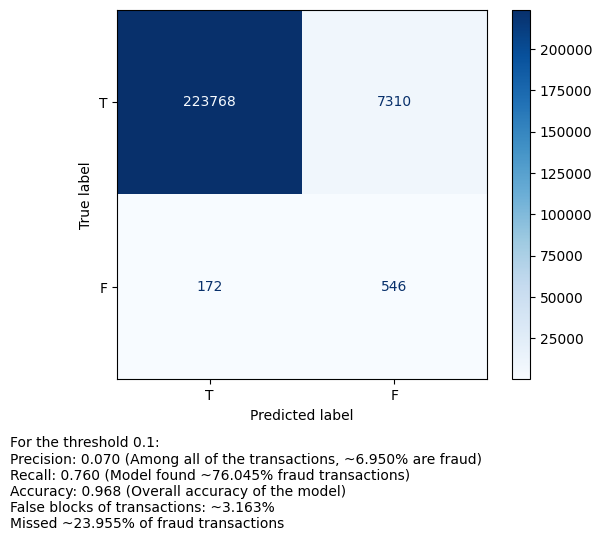

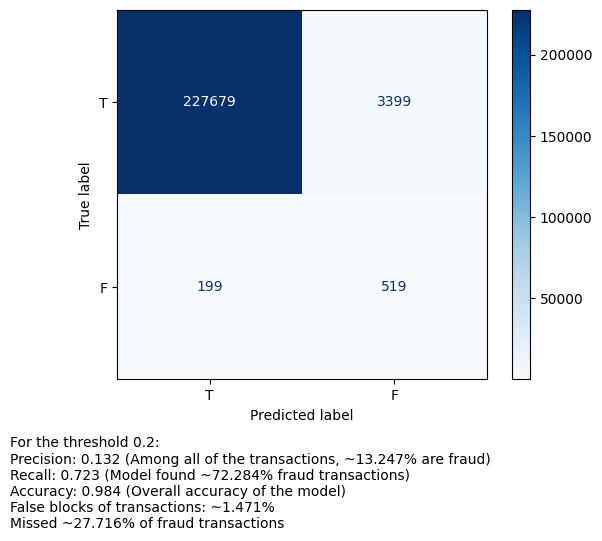

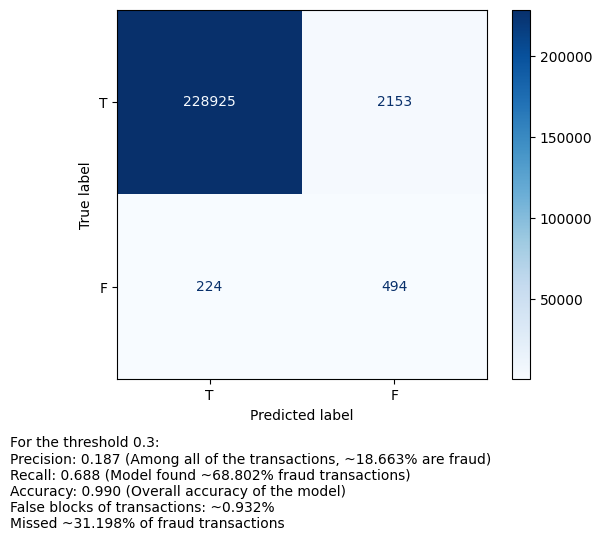

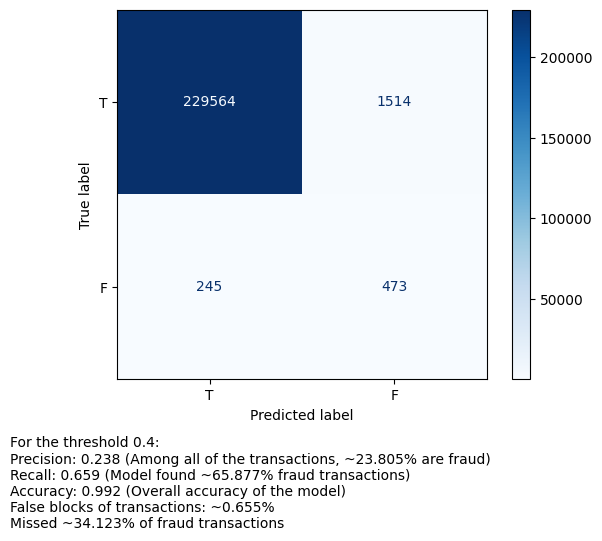

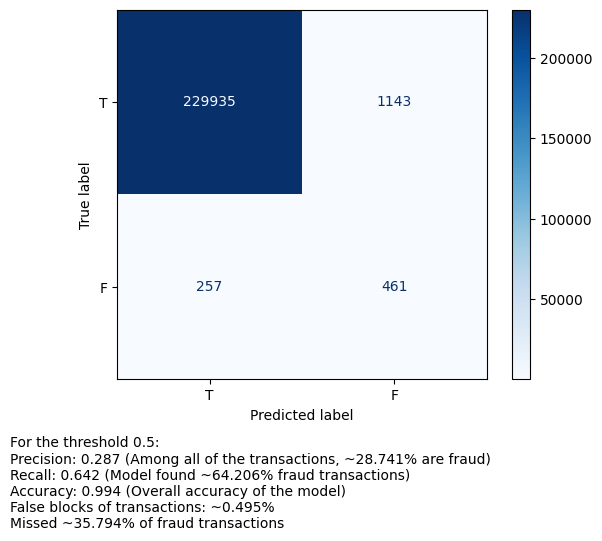

In [28]:
for thr in mark_thrs + [0.1, 0.2, 0.3, 0.4, 0.5]:
    conf_matrix = cm_for_threshold(thr, y_pred_proba, y_val)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['T', 'F'])
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

### Observations

* The less threshold is, the less number of missed transactions

## Tune model

* For tuning, use [optuna](https://github.com/optuna/optuna) library

In [41]:
import optuna

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    model = XGBClassifier(
        eval_metric='aucpr',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        tree_method='hist', 
        gpu_id=0, 
        predictor="cpu_predictor"
        ,**param 
    )
    model.fit(
        X_train[FEATURES], y_train,
        eval_set=[(X_val[FEATURES], y_val)], 
        verbose=False
    )
    pred_proba = model.predict_proba(X_val[FEATURES])[:, 1]
    score = average_precision_score(y_val, pred_proba)
    print("SCORE IS", score)
    return score

In [42]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

[I 2025-10-12 11:33:30,079] A new study created in memory with name: no-name-4a73cb4a-c04e-4306-ab3b-f7e9b459c14e
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.

SCORE IS 0.5723846281426692


/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt5800

SCORE IS 0.5906804474167698


/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_63444/1904267685.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt5800

SCORE IS 0.5689342536076841


In [43]:
study.best_trial.params

{'max_depth': 11,
 'subsample': 0.9,
 'n_estimators': 2300,
 'eta': 0.08,
 'reg_alpha': 14,
 'reg_lambda': 7,
 'min_child_weight': 19,
 'colsample_bytree': 0.8946111526982555}

In [46]:
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## Train with parameters

* Based on previous step, we are going to train model with best attributes and verify it on test scope

In [47]:
best_params = {
 'max_depth': 11,
 'subsample': 0.9,
 'n_estimators': 2300,
 'eta': 0.08,
 'reg_alpha': 14,
 'reg_lambda': 7,
 'min_child_weight': 19,
 'colsample_bytree': 0.8946111526982555
}
model = XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method='hist', 
    gpu_id=0, 
    predictor="cpu_predictor",
    **best_params
)
model.fit(
    X_train[FEATURES], y_train,
    eval_set=[(X_val[FEATURES], y_val)], 
    verbose=False
)
y_xgb_predict_proba = model.predict_proba(X_test[FEATURES])[:, 1]
roc_auc = roc_auc_score(y_test, y_xgb_predict_proba)
pr_auc = average_precision_score(y_test, y_xgb_predict_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC:  {pr_auc:.3f}")

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.954
PR AUC:  0.612


### Visualization

#### Precision-recall curve

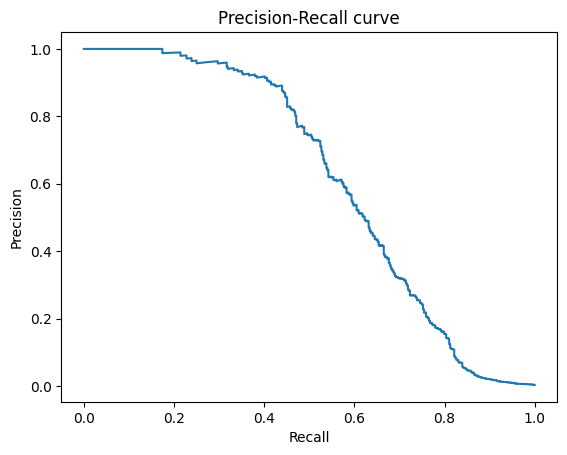

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_xgb_predict_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

#### Thresholds grid

In [64]:
grid = np.sort(np.unique(np.round(y_xgb_predict_proba, 3)))
rows = []

for t in sorted(set(grid)):
    y_hat = (y_xgb_predict_proba >= t).astype(int)
    
    pr = precision_score(y_test, y_hat, zero_division=0)
    rc = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    f05 = fbeta_score(y_test, y_hat, beta=0.5, zero_division=0)
    f2 = fbeta_score(y_test, y_hat, beta=2, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    fp_rate = fp / (fp + tn)
    
    rows.append((t, pr, rc, f1, f05, f2, tp, fp, fn, tn, fp_rate))

grid_df = pd.DataFrame(
    rows,
    columns=['thr', 'precision', 'recall', 'f1', 'f0.5', 'f2', 'TP', 'FP', 'FN', 'TN', 'fp_rate']
).sort_values('thr')

In [50]:
grid_df[grid_df['f1'] == grid_df['f1'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
602,0.921,0.727554,0.524554,0.609598,0.675287,0.555556,235,88,213,138311
603,0.922,0.727554,0.524554,0.609598,0.675287,0.555556,235,88,213,138311


In [51]:
grid_df[grid_df['f0.5'] == grid_df['f0.5'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
652,0.986,0.890909,0.4375,0.586826,0.737952,0.487078,196,24,252,138375


In [52]:
grid_df[grid_df['f2'] == grid_df['f2'].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
418,0.536,0.488774,0.631696,0.55112,0.511939,0.596795,283,296,165,138103


In [67]:
grid_df[(grid_df['recall'] > 0.6) & (grid_df['fp_rate'] < 0.05)].sort_values(by='f1', ascending=False)

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
473,0.647,0.537698,0.604911,0.569328,0.549919,0.590157,271,233,177,138166,0.001684
472,0.645,0.536634,0.604911,0.568730,0.549028,0.589900,271,234,177,138165,0.001691
474,0.649,0.536779,0.602679,0.567823,0.548780,0.588235,270,233,178,138166,0.001684
471,0.644,0.534517,0.604911,0.567539,0.547254,0.589387,271,236,177,138163,0.001705
470,0.639,0.534517,0.604911,0.567539,0.547254,0.589387,271,236,177,138163,0.001705
...,...,...,...,...,...,...,...,...,...,...,...
9,0.009,0.089822,0.821429,0.161936,0.109290,0.312447,368,3729,80,134670,0.026944
8,0.008,0.082867,0.825893,0.150621,0.101049,0.295669,370,4095,78,134304,0.029588
7,0.007,0.075841,0.830357,0.138987,0.092685,0.277736,372,4533,76,133866,0.032753
6,0.006,0.068128,0.839286,0.126026,0.083467,0.257147,376,5143,72,133256,0.037161


#### Precision-recall curve with thresholds

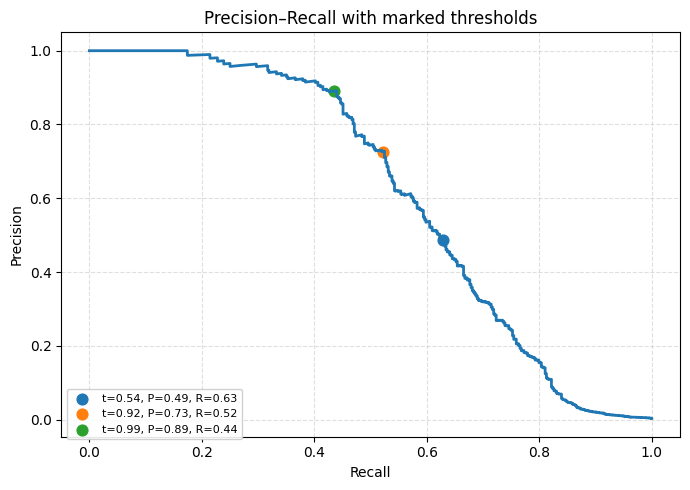

In [55]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(recall, precision, lw=2)

mark_thrs = [0.536, 0.922, 0.986]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles=[]
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc='lower left')

ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

#### Confusion matrices for thresholds

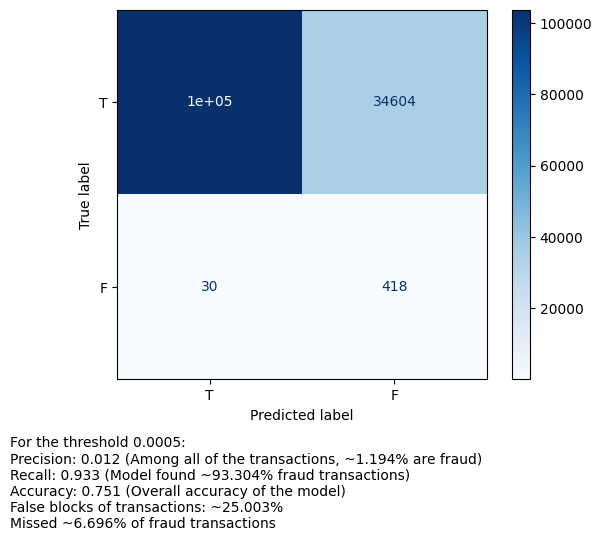

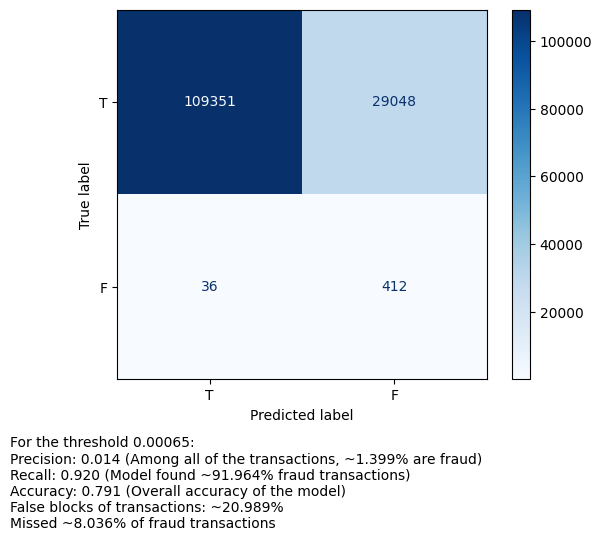

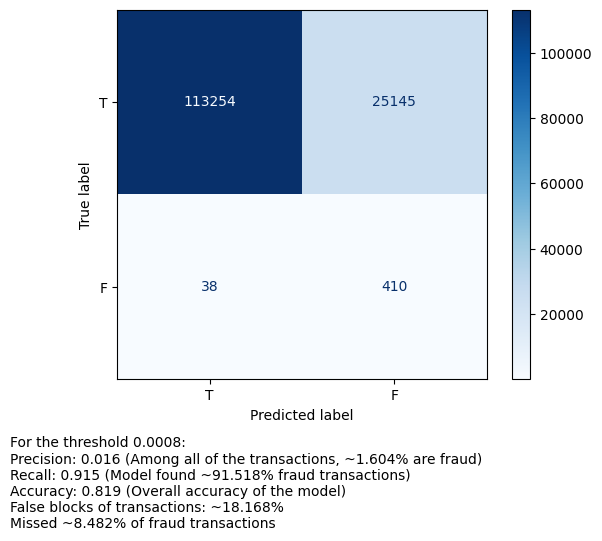

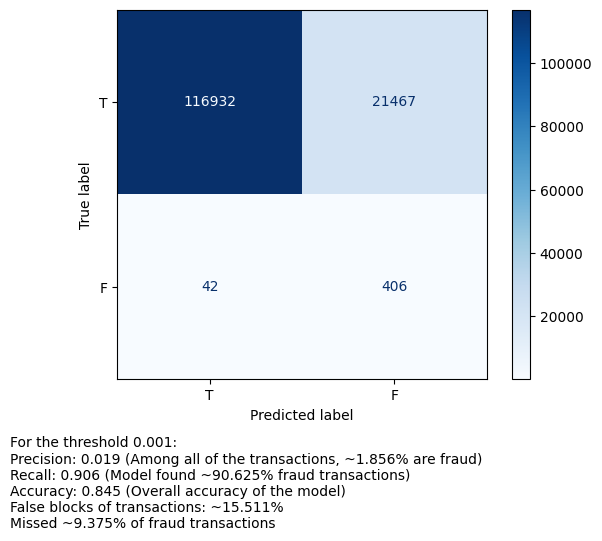

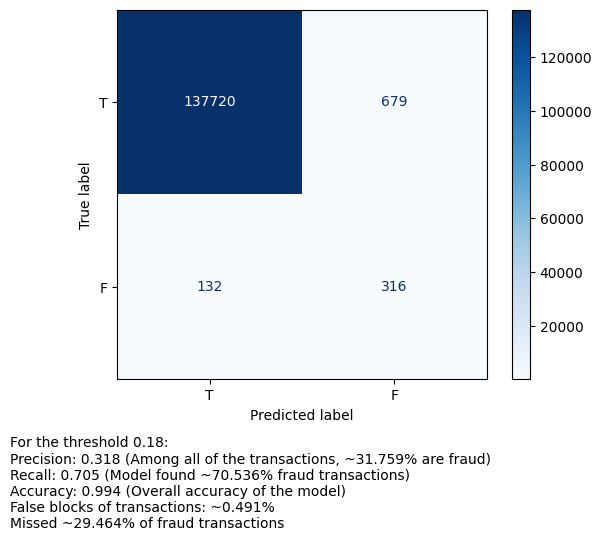

In [63]:
for thr in [0.0005, 0.00065, 0.0008, 0.001, 0.18]:
    conf_matrix = cm_for_threshold(thr, y_xgb_predict_proba, y_test)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['T', 'F'])
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

## Observations

* Best model result is achived with threshold = `0.001`

## Features importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

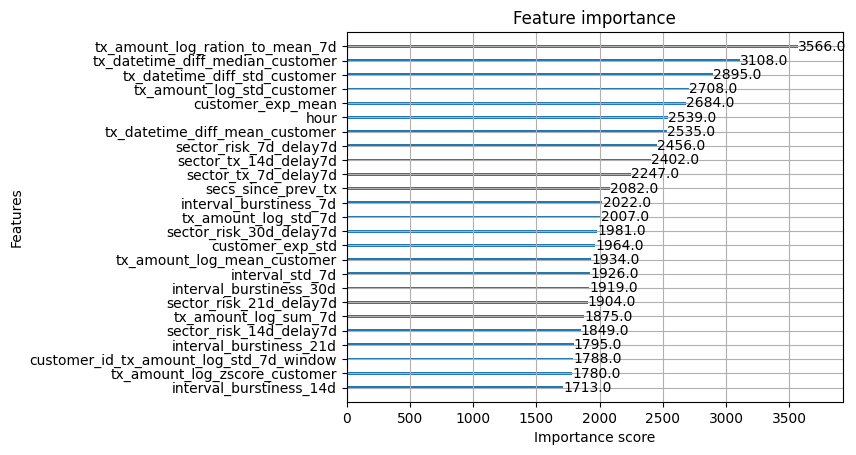

In [74]:
plot_importance(model, max_num_features=25)

## Save the model

In [68]:
model.save_model(DATA / "models/xgboost.json")

In [75]:
loaded_model = XGBClassifier()
loaded_model.load_model(DATA / "models/xgboost.json")

In [76]:
%%time

loaded_model.predict(X_test[FEATURES])

CPU times: user 6.94 s, sys: 137 ms, total: 7.07 s
Wall time: 1.22 s


array([0, 0, 1, ..., 0, 0, 0], shape=(138847,))